In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Parameters
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
NUM_CLASSES = 3

# Dataset and DataLoader
# Define transformations for data preprocessing
# Dataset transformations
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * CHANNELS, [0.5] * CHANNELS)  # Normalize with mean=0.5, std=0.5
])

# Load dataset
dataset = datasets.ImageFolder("/kaggle/input/plantvillage/PlantVillage", transform=transform)
class_names = dataset.classes

# Train/Val/Test Split
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)



In [5]:
len(dataset)

2152

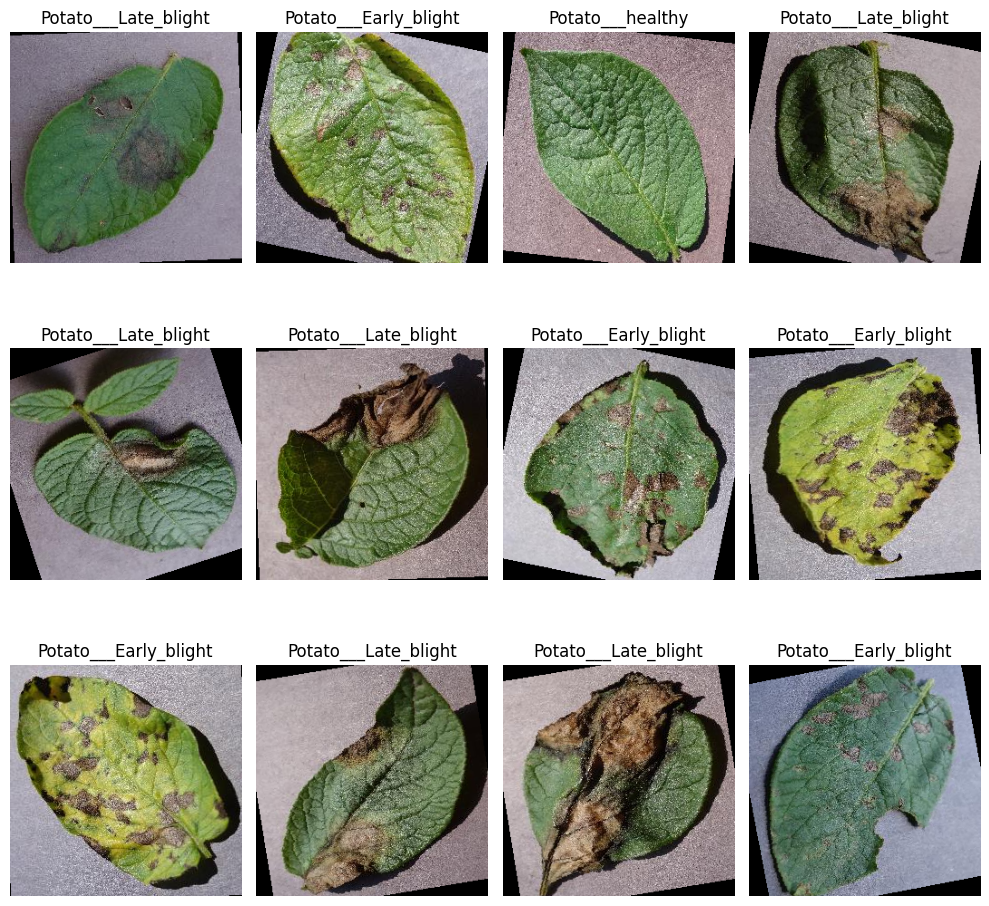

In [9]:
# Visualize some images
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(3, 4, figsize=(10, 10))
axes = axes.ravel()
for i in range(12):
    image = images[i].permute(1, 2, 0) * 0.5 + 0.5  # Unnormalize
    axes[i].imshow(image)
    axes[i].set_title(class_names[labels[i]])
    axes[i].axis("off")
plt.tight_layout()
plt.show()

In [14]:
class CNNModel(nn.Module):
    def __init__(self, n_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(CHANNELS, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        # Dummy input to compute the size after convolutional layers
        with torch.no_grad():
            dummy_input = torch.randn(1, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
            dummy_output = self.features(dummy_input)
            self.flattened_size = dummy_output.view(-1).size(0)

        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        return self.classifier(x)
n_classes = len(class_names)
model = CNNModel(n_classes)
model


CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=12544, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [15]:
def debug_model_shape(model, input_shape):
    x = torch.randn(input_shape)  # Simulate a batch of inputs
    for layer in model.features:
        x = layer(x)
        print(f"{layer}: Output shape: {x.shape}")
    x = x.view(x.size(0), -1)
    print(f"Flatten: Output shape: {x.shape}")
    for layer in model.classifier:
        x = layer(x)
        print(f"{layer}: Output shape: {x.shape}")

# Example usage
debug_model_shape(model, (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE))


Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1)): Output shape: torch.Size([32, 32, 254, 254])
ReLU(): Output shape: torch.Size([32, 32, 254, 254])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): Output shape: torch.Size([32, 32, 127, 127])
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)): Output shape: torch.Size([32, 64, 125, 125])
ReLU(): Output shape: torch.Size([32, 64, 125, 125])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): Output shape: torch.Size([32, 64, 62, 62])
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)): Output shape: torch.Size([32, 64, 60, 60])
ReLU(): Output shape: torch.Size([32, 64, 60, 60])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): Output shape: torch.Size([32, 64, 30, 30])
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)): Output shape: torch.Size([32, 64, 28, 28])
ReLU(): Output shape: torch.Size([32, 64, 28, 28])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [16]:

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch 1/50: Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 0.0027, Val Accuracy: 1.0000
Epoch 2/50: Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 0.0013, Val Accuracy: 1.0000
Epoch 3/50: Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 0.0002, Val Accuracy: 1.0000
Epoch 4/50: Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 0.0001, Val Accuracy: 1.0000
Epoch 5/50: Train Loss: 0.0000, Train Accuracy: 1.0000, Val Loss: 0.0017, Val Accuracy: 1.0000
Epoch 6/50: Train Loss: 0.0009, Train Accuracy: 0.9994, Val Loss: 0.0069, Val Accuracy: 0.9953
Epoch 7/50: Train Loss: 0.2243, Train Accuracy: 0.9338, Val Loss: 0.0472, Val Accuracy: 0.9767
Epoch 8/50: Train Loss: 0.0807, Train Accuracy: 0.9739, Val Loss: 0.0536, Val Accuracy: 0.9860
Epoch 9/50: Train Loss: 0.0295, Train Accuracy: 0.9884, Val Loss: 0.0290, Val Accuracy: 0.9953
Epoch 10/50: Train Loss: 0.0249, Train Accuracy: 0.9890, Val Loss: 0.0185, Val Accuracy: 0.9907
Epoch 11/50: Train Loss: 0.0124, Train Accuracy: 

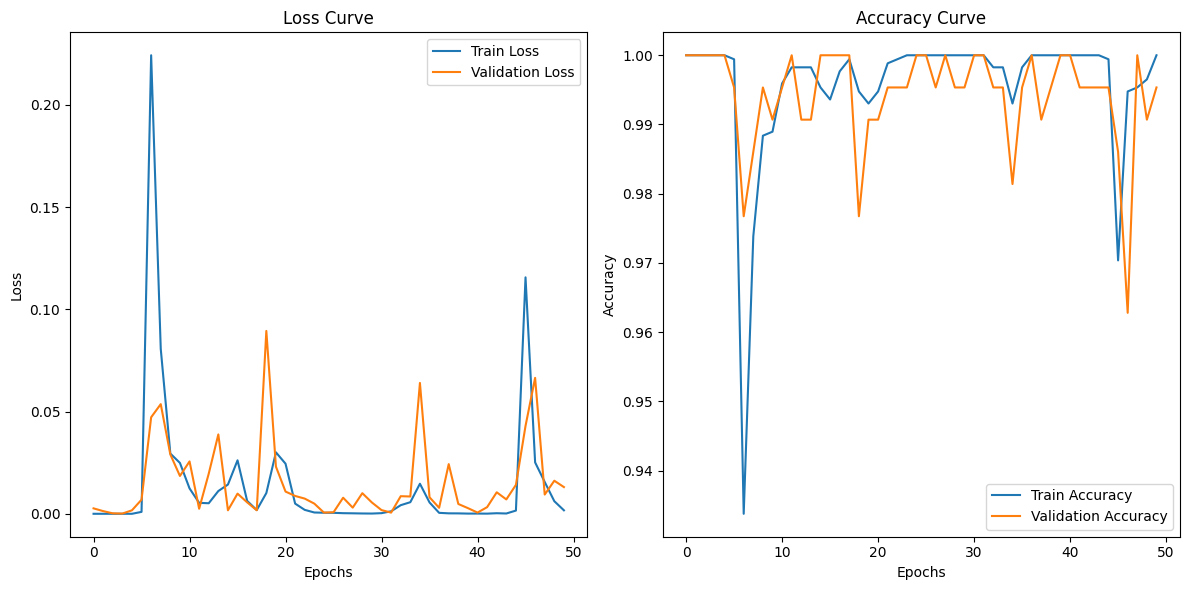

In [ ]:
import torch

# Define the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

import matplotlib.pyplot as plt


# Lists to store training history
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()  # Ensure the model is in training mode
        train_loss, train_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        # Validation Phase
        model.eval()  # Ensure the model is in evaluation mode
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        # Store losses and accuracies
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_correct / len(train_ds))
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / len(val_ds))

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_correct/len(train_ds):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Val Accuracy: {val_correct/len(val_ds):.4f}")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS)

# Plot Training History
plt.figure(figsize=(12, 6))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [25]:

# Test the Model
model.eval()  # Ensure the model is in evaluation mode
test_loss, test_correct = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        test_correct += (outputs.argmax(1) == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}, "
      f"Test Accuracy: {test_correct/len(test_ds):.4f}")


     

Test Loss: 0.0432, Test Accuracy: 0.9815


In [26]:

# Save the model
model_path = "./models"
os.makedirs(model_path, exist_ok=True)
model_version = len(os.listdir(model_path)) + 1
model_filepath = f"{model_path}/model_{model_version}.pth"
torch.save(model.state_dict(), model_filepath)

print(f"Model saved to {model_filepath}")

# Zip the saved models
import shutil
zip_filepath = f"./models_{model_version}.zip"
shutil.make_archive(zip_filepath.replace(".zip", ""), "zip", model_path)
print(f"Models zipped as: {zip_filepath}")

Model saved to ./models/model_4.pth
Models zipped as: ./models_4.zip
